# Tourism Classification
<img src='header.png' width='880'>

The dataset describes 24,675 rows of up-to-date information on tourist expenditure collected by the National Bureau of Statistics (NBS) in Tanzania.The dataset was collected to gain a better understanding of the status of the tourism sector and provide an instrument that will enable sector growth.

Your goal is to accurately classify the range of expenditures a tourist spends in Tanzania.

The majority of the visitors under the age group of 25-44 came for business (18.5%), or leisure and holidays (53.2%), which is consistent with the fact that they are economically more productive. Those at the age group of 45-64 were more prominent in holiday making and visiting friends and relatives. The results further reveal that most visitors belonging to the age group of 18-24 came for leisure and holidays (55.3%) as well as volunteering (13.7%). The majority of senior citizens (65 and above) came for leisure and holidays (80.9%) and visiting friends and relatives (9.5%).

The survey covers seven departure points, namely: Julius Nyerere International Airport, Kilimanjaro International Airport, Abeid Amani Karume International Airport, and the Namanga, Tunduma, Mtukula and Manyovu border points.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib . pyplot as plt
sns.set_style('darkgrid')
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette('Accent')
import plotly.express as px
import plotly.io as pio
from numpy.random import seed
seed(42)
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.utils.class_weight import compute_sample_weight

from skopt import gp_minimize, BayesSearchCV
from skopt.plots import plot_convergence, plot_gaussian_process
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args

In [2]:
df_dict = pd.read_csv('VariableDefinitions.csv')
TrainDF = pd.read_csv('Train.csv')
TestDF = pd.read_csv('Test.csv')

In [3]:
TrainDF.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [4]:
TestDF.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [5]:
df_dict

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


In [6]:
TrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [7]:
TrainDF.describe()

,total_female,total_male,night_mainland,night_zanzibar
count,18504.000000,18500.000000,18506.000000,18506.000000
mean,0.936230,0.998757,9.141576,2.493516
std,1.215582,1.173177,14.127449,5.275156
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,3.000000,0.000000
50%,1.000000,1.000000,6.000000,0.000000
75%,1.000000,1.000000,11.000000,4.000000
max,49.000000,58.000000,365.000000,240.000000


In [8]:
TrainDF.select_dtypes(['object']).describe().T

,count,unique,top,freq
Tour_ID,18506,18506,tour_id1hffseyw,1
country,18506,131,UNITED STATES OF AMERICA,2846
age_group,18506,5,25-44,9047
travel_with,17431,5,Alone,7590
purpose,18506,8,Leisure and Holidays,11755
main_activity,18506,10,Widlife Tourism,5988
info_source,18506,8,"Travel agent, tour operator",8005
tour_arrangement,18506,2,Package Tour,9295
package_transport_int,18506,2,No,12238
package_accomodation,18506,2,No,9541


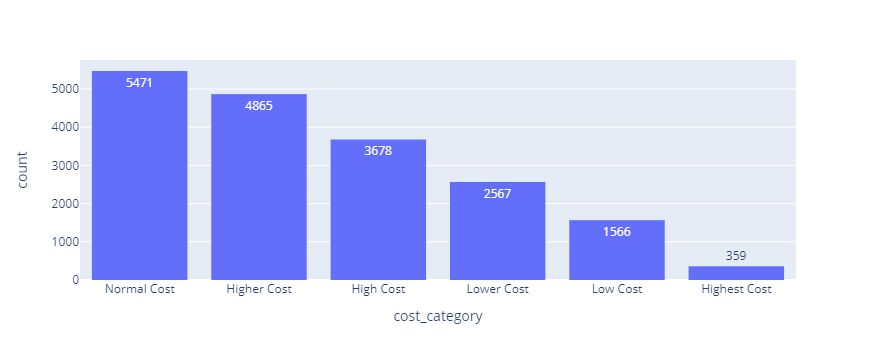

In [9]:
px.histogram(TrainDF,x='cost_category',text_auto=True).update_xaxes(categoryorder="total descending")

In [10]:
TrainDF.isna().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with              1075
total_female                2
total_male                  6
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category               0
dtype: int64

In [11]:
TestDF.isna().sum()

Tour_ID                    0
country                    0
age_group                  0
travel_with              361
total_female               2
total_male                 1
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
first_trip_tz              0
dtype: int64

<AxesSubplot:>

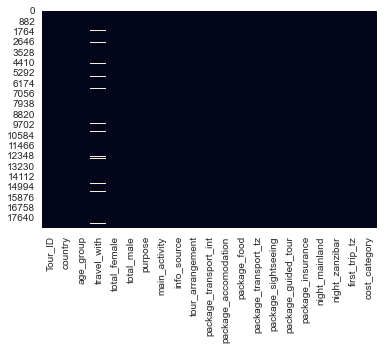

In [12]:
sns.heatmap(TrainDF.isna(), annot=False, cbar=False)

### handle missing data
let's fill this missing data in train and test set

In [13]:
def missingCols(df):
    df = df.isna().sum()
    return df[df>0]

In [14]:
missingCols(TrainDF)

travel_with     1075
total_female       2
total_male         6
dtype: int64

In [15]:
missingCols(TestDF)

travel_with     361
total_female      2
total_male        1
dtype: int64

In [16]:
df_dict[df_dict['Column Name'] == "travel_with"]['Definition'].values[0]

'The relation of people a tourist travel with to Tanzania'

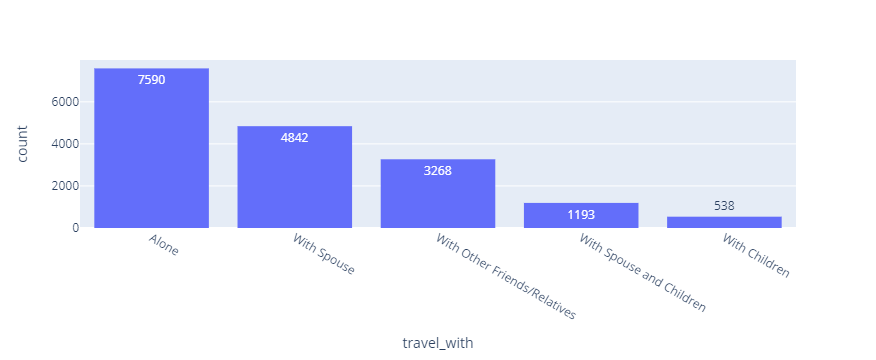

In [17]:
px.histogram(TrainDF,x='travel_with',text_auto=True).update_xaxes(categoryorder="total descending")

**we will fill this missing travel_with with an unknown**
but first let's explore the total female and total male missing

<AxesSubplot:xlabel='total_male'>

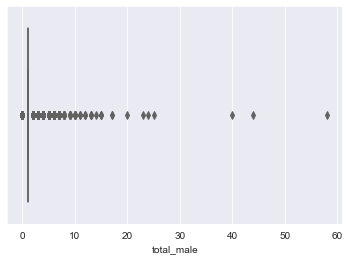

In [18]:
sns.boxplot(data = TrainDF, x ='total_male')

In [19]:
TrainDF[TrainDF['total_male'].isna()]

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
6195,tour_idcfe5lv3z,SOUTH AFRICA,25-44,With Other Friends/Relatives,0.0,NaN,Meetings and Conference,Wildlife Tourism,"Newspaper, magazines, brochures",Independent,...,No,No,No,No,No,No,4,0,Yes,Normal Cost
7092,tour_idzmkp9sq6,CHINA,25-44,With Other Friends/Relatives,10.0,NaN,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,Yes,4,2,Yes,Highest Cost
9350,tour_idgxm5bafr,SPAIN,45-64,With Other Friends/Relatives,7.0,NaN,Other,Hunting Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,Yes,11,0,No,Highest Cost
9571,tour_idaqxaa6li,FRANCE,25-44,NaN,0.0,NaN,Leisure and Holidays,Conference Tourism,"Radio, TV, Web",Package Tour,...,Yes,Yes,Yes,Yes,Yes,Yes,6,0,Yes,Normal Cost
13076,tour_id7rzn4czm,GERMANY,45-64,With Other Friends/Relatives,4.0,NaN,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,Yes,23,0,No,Higher Cost
15585,tour_id41dez9e2,NETHERLANDS,45-64,With Other Friends/Relatives,11.0,NaN,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,No,Yes,No,No,Yes,No,5,0,Yes,Higher Cost


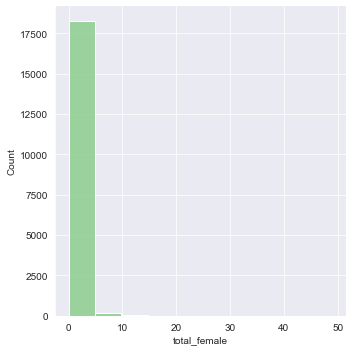

In [20]:
sns.displot(TrainDF['total_female'], bins=10)

In [21]:
TrainDF[TrainDF['total_female'].isna()]

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
7627,tour_idsgxazh59,FRANCE,25-44,With Other Friends/Relatives,NaN,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,Yes,9,5,Yes,Lower Cost
8388,tour_id1kmucs2v,ITALY,18-24,With Other Friends/Relatives,NaN,4.0,Volunteering,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,15,0,Yes,High Cost


In [22]:
TrainDF['total_male'].median()

1.0

In [23]:
TrainDF['travel_with'] = TrainDF['travel_with'].fillna(value="unknown")
TrainDF['total_female'] = TrainDF['total_female'].fillna(value=TrainDF['total_female'].median())
TrainDF['total_male'] = TrainDF['total_male'].fillna(value=TrainDF['total_male'].median())

In [24]:
TestDF['travel_with'] = TestDF['travel_with'].fillna(value="unknown")
TestDF['total_female'] = TestDF['total_female'].fillna(value=TrainDF['total_female'].median())
TestDF['total_male'] = TestDF['total_male'].fillna(value=TrainDF['total_male'].median())

In [25]:
sum(TestDF.isna().sum())

0

#### Prepare Data

In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split

In [27]:
X = TrainDF.drop(['Tour_ID','cost_category'], axis=1)

X_cat = X.select_dtypes(['object'])
X_int = X.select_dtypes(exclude=['object'])

X_cat = pd.get_dummies(X_cat, drop_first=True)
X = pd.concat([X_cat, X_int], axis=1)

y = TrainDF['cost_category']


In [28]:
y = LabelEncoder().fit_transform(y)

In [44]:
encoder =OneHotEncoder(drop='first',sparse=False)
#X = encoder.fit_transform(X_cat)
scaler = StandardScaler()

In [45]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42, stratify=y)

In [46]:
#y_train.value_counts()

In [47]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Build a model

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix

#### Logistic Regression

Accuracy fo model 45.43%


              precision    recall  f1-score   support

           0       0.45      0.46      0.45       368
           1       0.64      0.52      0.58       486
           2       0.14      0.64      0.23        36
           3       0.21      0.39      0.28       157
           4       0.49      0.52      0.51       257
           5       0.56      0.36      0.44       547

    accuracy                           0.45      1851
   macro avg       0.42      0.48      0.41      1851
weighted avg       0.51      0.45      0.47      1851





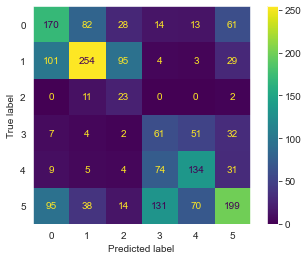

In [93]:
logistic_model = LogisticRegression( max_iter=500, class_weight='balanced')

logistic_model.fit(X_train,y_train)

logistic_pred = logistic_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,logistic_pred)*100))

print("\n")

print(classification_report(y_test,logistic_pred))

print("\n")

plot_confusion_matrix(logistic_model,X_test,y_test)
plt.grid(None)

#### RandomForest

In [94]:
from sklearn.ensemble import RandomForestClassifier

Accuracy fo model 54.02%


              precision    recall  f1-score   support

           0       0.48      0.31      0.38       368
           1       0.63      0.79      0.70       486
           2       0.33      0.08      0.13        36
           3       0.22      0.10      0.14       157
           4       0.53      0.54      0.54       257
           5       0.52      0.63      0.57       547

    accuracy                           0.54      1851
   macro avg       0.45      0.41      0.41      1851
weighted avg       0.51      0.54      0.52      1851





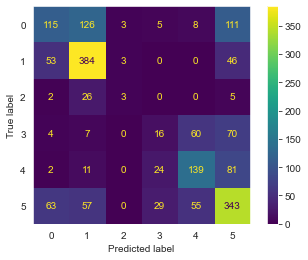

In [96]:
rf_model = RandomForestClassifier(class_weight='balanced_subsample')

rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,rf_pred)*100))

print("\n")

print(classification_report(y_test,rf_pred))

print("\n")

plot_confusion_matrix(rf_model,X_test,y_test)
plt.grid(None)

#### SVC

In [37]:
from sklearn.svm import SVC

Accuracy fo model 55.32%


              precision    recall  f1-score   support

           0       0.48      0.39      0.43       368
           1       0.64      0.77      0.70       486
           2       0.00      0.00      0.00        36
           3       0.00      0.00      0.00       157
           4       0.55      0.59      0.57       257
           5       0.52      0.65      0.57       547

    accuracy                           0.55      1851
   macro avg       0.36      0.40      0.38      1851
weighted avg       0.49      0.55      0.52      1851





C:\Users\matty\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\matty\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\matty\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



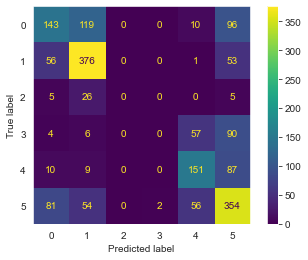

In [38]:
svc_model = SVC()

svc_model.fit(X_train,y_train)

sv_pred = svc_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,sv_pred)*100))

print("\n")

print(classification_report(y_test,sv_pred))

print("\n")

plot_confusion_matrix(svc_model,X_test,y_test)
plt.grid(None)

#### Gradient Boosting Optimized

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV 

In [38]:
# set up the model
gbm = GradientBoostingClassifier(random_state=42)

param_grid = [Integer(10,300,name='n_estimators'),
             Integer(1,5, name='max_depth')]

In [39]:
# objective function

@use_named_args(param_grid)
def objective(**params):
    
    #model with new parameter
    gbm.set_params(**params)
    
    # optimization function (hyper parameter response function)
    value = np.mean(
            cross_val_score(gbm,X_train,y_train, cv=3,n_jobs=-1, scoring='neg_log_loss')
    )
    
    
    # negative metric because we need to minimize
    return -value

In [40]:
gp_ = gp_minimize(objective,
                  param_grid,
                  n_initial_points=10,
                  acq_func='EI',
                  n_calls=20,
                  random_state=42)

In [42]:
gp_.x

[236, 3]

In [43]:
gp_.fun

1.1247078676232327

In [ ]:
gp_.

Accuracy fo model 49.59%


              precision    recall  f1-score   support

           0       0.47      0.44      0.46       368
           1       0.66      0.63      0.65       486
           2       0.17      0.53      0.25        36
           3       0.23      0.43      0.30       157
           4       0.55      0.53      0.54       257
           5       0.59      0.41      0.49       547

    accuracy                           0.50      1851
   macro avg       0.44      0.50      0.45      1851
weighted avg       0.54      0.50      0.51      1851





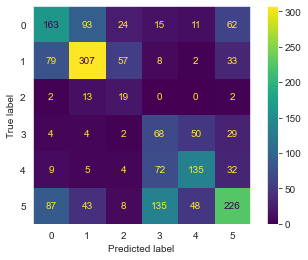

In [44]:
rf_model = GradientBoostingClassifier(n_estimators=236,max_depth=3,random_state=42)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y= y_train
    
)

rf_model.fit(X_train,y_train,sample_weight=sample_weights)

rf_pred = rf_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,rf_pred)*100))

print("\n")

print(classification_report(y_test,rf_pred))

print("\n")

plot_confusion_matrix(rf_model,X_test,y_test)
plt.grid(None)

In [41]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y= y_train
)

In [98]:
param_grid = { 'n_estimators': (10,300),
               'max_depth': (1,5) }

In [99]:
Bsearch = BayesSearchCV(estimator =gbm,
                       search_spaces=param_grid,
                       scoring='f1_weighted',
                       cv=3,
                       n_iter = 20,
                       random_state=42,
                       n_jobs=-1,
                       refit=True)


In [100]:
Bsearch.fit(X_train,y_train, sample_weight=sample_weights)

C:\Users\matty\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



BayesSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
              n_iter=20, n_jobs=-1, random_state=42, scoring='f1_weighted',
              search_spaces={'max_depth': (1, 5), 'n_estimators': (10, 300)})

In [101]:
Bsearch.best_params_

OrderedDict([('max_depth', 5), ('n_estimators', 300)])

Accuracy fo model 50.57%


              precision    recall  f1-score   support

           0       0.46      0.45      0.45       368
           1       0.65      0.66      0.65       486
           2       0.16      0.33      0.22        36
           3       0.24      0.38      0.29       157
           4       0.54      0.54      0.54       257
           5       0.58      0.44      0.50       547

    accuracy                           0.51      1851
   macro avg       0.44      0.47      0.44      1851
weighted avg       0.53      0.51      0.51      1851





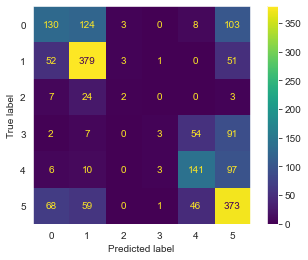

In [102]:
rf_pred = Bsearch.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,rf_pred)*100))

print("\n")

print(classification_report(y_test,rf_pred))

print("\n")

plot_confusion_matrix(rf_model,X_test,y_test)
plt.grid(None)

#### Xgboost

In [97]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [98]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y= y_train
)

In [274]:
Xg_model = XGBClassifier()

In [275]:
Xg_model.fit(X_train,y_train,sample_weight=sample_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Accuracy fo model 51.43%


              precision    recall  f1-score   support

           0       0.46      0.46      0.46       368
           1       0.65      0.68      0.67       486
           2       0.24      0.50      0.33        36
           3       0.22      0.32      0.26       157
           4       0.53      0.56      0.54       257
           5       0.60      0.44      0.51       547

    accuracy                           0.51      1851
   macro avg       0.45      0.49      0.46      1851
weighted avg       0.54      0.51      0.52      1851





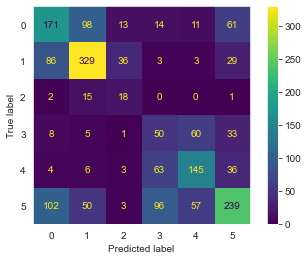

In [276]:
Xg_pred = Xg_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,Xg_pred)*100))

print("\n")

print(classification_report(y_test,Xg_pred))

print("\n")

plot_confusion_matrix(Xg_model,X_test,y_test)
plt.grid(None)

##### Xgboost scikit optimize

In [377]:
# set up the model
xgb = XGBClassifier(random_state=42,seed=42)

weight_dic  = {0 :0.798746,
 1 :0.584621,
 2 :1.795634,
 3 :1.52888,
 4 :0.798746,
 5 :0.819399}
sample_weights = compute_sample_weight(
    class_weight=weight_dic,
    y= y_train
)

# defining the space
param_grid = { 'colsample_bylevel': (0.6,0.7),
              'colsample_bytree': (0.6,0.7),
              'gamma': (0.01,1),
              'learning_rate': (0.0001,1),
              'max_delta_step': (0.1,10),
              'n_estimators': (10,20),
              'min_child_weight': (10,500),
               'max_depth': (6,15),
             'reg_alpha': (0.1,200),
               'reg_lambda': (0.1,100),
             'subsample': (0.4,0.7)
             }

In [380]:
BsearchXGB = BayesSearchCV(estimator =xgb,
                       search_spaces=param_grid,
                       scoring='neg_log_loss',
                       cv=3,
                       n_iter = 50,
                       random_state=42,
                       n_jobs=-1,
                       refit=True, verbose=10)


In [381]:
BsearchXGB.fit(X_train,y_train,sample_weight=sample_weights)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=None, gpu_id=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_bin=None,
                                      max_c...
                                      reg_lambda=None, ...),
              n_jobs=-1, random_state=42, scoring='neg_log_loss',
              search_spaces={'colsample_bylevel': (0.6, 0.7),
                             'colsample_bytree

In [382]:
BsearchXGB.best_params_

OrderedDict([('colsample_bylevel', 0.6),
             ('colsample_bytree', 0.7),
             ('gamma', 0.04685898657677962),
             ('learning_rate', 0.44439900454554765),
             ('max_delta_step', 10.0),
             ('max_depth', 15),
             ('min_child_weight', 10),
             ('n_estimators', 20),
             ('reg_alpha', 0.1),
             ('reg_lambda', 22.806963606914223),
             ('subsample', 0.7)])

Accuracy fo model 55.32%


              precision    recall  f1-score   support

           0       0.50      0.42      0.45       368
           1       0.68      0.71      0.69       486
           2       0.41      0.42      0.41        36
           3       0.22      0.24      0.23       157
           4       0.60      0.46      0.52       257
           5       0.57      0.65      0.61       547

    accuracy                           0.55      1851
   macro avg       0.49      0.48      0.48      1851
weighted avg       0.55      0.55      0.55      1851





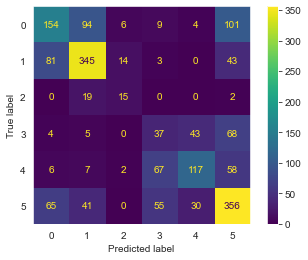

In [383]:
Xg_pred = BsearchXGB.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,Xg_pred)*100))

print("\n")

print(classification_report(y_test,Xg_pred))

print("\n")

plot_confusion_matrix(BsearchXGB,X_test,y_test)
plt.grid(None)

#### Catboost

In [112]:
TrainDF['cost_category'].value_counts()/len(TrainDF['cost_category'])

Normal Cost     0.295634
Higher Cost     0.262888
High Cost       0.198746
Lower Cost      0.138712
Low Cost        0.084621
Highest Cost    0.019399
Name: cost_category, dtype: float64

In [113]:
le.classes_

array(['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost',
       'Lower Cost', 'Normal Cost'], dtype=object)

In [49]:
weights =  [0.598746,0.384621,1.795634,1.52888,0.598746,0.519399]
weights2 = [0.798746,0.584621,1.795634,1.52888,0.798746,0.819399] #ruling
weights3 = [0.798746,0.584621,2.99634,2.4888,0.998746,0.859399]

In [110]:
set(sample_weights)

{0.5637354454373138,
 0.6338966278450179,
 0.8386203423967774,
 1.2016594516594516,
 1.9700733380648214,
 8.593911248710011}

In [125]:
class_w = {0: 1.198746,
            1: 1.262888,
            2: 2.019399,
            3: 2.984621,
            4: 2.138712,
            5: 1.295634 }

In [161]:
cat_model = CatBoostClassifier(
   auto_class_weights='SqrtBalanced', 
   random_state= 42,
   iterations=5000,
)#custom_loss=[metrics.AUC()],
#class_weights=weights2,auto_class_weights='SqrtBalanced'

In [ ]:
cat_model.fit(X_train,y_train)

Learning rate set to 0.023442
0:	learn: 1.7879979	total: 17ms	remaining: 1m 25s
1:	learn: 1.7786841	total: 29ms	remaining: 1m 12s
2:	learn: 1.7759299	total: 35.2ms	remaining: 58.6s
3:	learn: 1.7647652	total: 40.8ms	remaining: 51s
4:	learn: 1.7618172	total: 45.2ms	remaining: 45.2s
5:	learn: 1.7592842	total: 49.4ms	remaining: 41.1s
6:	learn: 1.7569051	total: 53.3ms	remaining: 38s
7:	learn: 1.7546706	total: 55.9ms	remaining: 34.9s
8:	learn: 1.7442553	total: 59.5ms	remaining: 33s
9:	learn: 1.7314014	total: 62.9ms	remaining: 31.4s
10:	learn: 1.7237247	total: 67ms	remaining: 30.4s
11:	learn: 1.7145868	total: 69.7ms	remaining: 29s
12:	learn: 1.7116735	total: 73.3ms	remaining: 28.1s
13:	learn: 1.7099202	total: 75.9ms	remaining: 27s
14:	learn: 1.7066019	total: 79.6ms	remaining: 26.5s
15:	learn: 1.7041731	total: 83.4ms	remaining: 26s
16:	learn: 1.7026297	total: 86.1ms	remaining: 25.2s
17:	learn: 1.6943459	total: 88.8ms	remaining: 24.6s
18:	learn: 1.6929238	total: 91.4ms	remaining: 23.9s
19:	lear

Accuracy fo model 55.86%


              precision    recall  f1-score   support

           0       0.48      0.40      0.44       368
           1       0.65      0.73      0.68       486
           2       0.33      0.36      0.35        36
           3       0.40      0.12      0.19       157
           4       0.53      0.61      0.57       257
           5       0.56      0.63      0.59       547

    accuracy                           0.56      1851
   macro avg       0.49      0.48      0.47      1851
weighted avg       0.54      0.56      0.54      1851





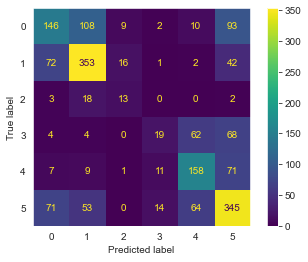

In [ ]:
cat_pred = cat_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,cat_pred)*100))

print("\n")

print(classification_report(y_test,cat_pred))

print("\n")

plot_confusion_matrix(cat_model,X_test,y_test)
plt.grid(None)

Accuracy fo model 55.59%


              precision    recall  f1-score   support

           0       0.49      0.44      0.46       368
           1       0.68      0.71      0.69       486
           2       0.32      0.25      0.28        36
           3       0.26      0.27      0.26       157
           4       0.61      0.49      0.54       257
           5       0.56      0.63      0.59       547

    accuracy                           0.56      1851
   macro avg       0.49      0.46      0.47      1851
weighted avg       0.55      0.56      0.55      1851





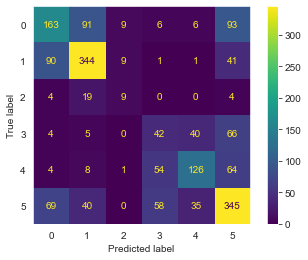

In [284]:
cat_pred = cat_model.predict(X_test)

print("Accuracy fo model {0:.2f}%".format(accuracy_score(y_test,cat_pred)*100))

print("\n")

print(classification_report(y_test,cat_pred))

print("\n")

plot_confusion_matrix(cat_model,X_test,y_test)
plt.grid(None)

##### catboost Optuna 

In [153]:
import catboost as cb
import optuna
from sklearn.metrics import accuracy_score,recall_score,f1_score

In [157]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split( X, y, test_size=0.1, random_state=42, stratify=y)

    param = {
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced", "SqrtBalanced"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    f1 = f1_score(valid_y, pred_labels,average='micro')
    return f1

In [158]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-06-29 16:15:41,517] A new study created in memory with name: no-name-6432bdf9-29c0-4b90-a3d6-1d1449d46d1f
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-06-29 16:15:44,855] Trial 0 finished with value: 0.3236088600756348 and parameters: {'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.03449557520789994, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.3236088600756348.
[I 2022-06-29 16:16:27,730] Trial 1 finished with value: 0.45326850351161535 and parameters: {'auto_class_weights': 'SqrtBalanced', 'colsample_bylevel': 0.08015507023224513, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.841590647444463}. Best is trial 1 with value: 0.45326850351161535.
[I 2022-06-29 16:16:31,928] Trial 2 finished with value: 0.39330091842247433 and parameters: {'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.07759275768710204, '

In [159]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.47487844408427876
  Params: 
    auto_class_weights: SqrtBalanced
    colsample_bylevel: 0.011283866609474212
    depth: 3
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.105637815860404


#### Build Full model | Prepare Data

In [62]:
print(TrainDF.shape)
print(TestDF.shape)

(18506, 21)
(6169, 20)


In [63]:
TrainDF['T'] = 1
TestDF['T'] = 0

In [64]:
fullDF = pd.concat([TrainDF,TestDF], axis=0)

In [65]:
fullDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24675 entries, 0 to 6168
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                24675 non-null  object 
 1   country                24675 non-null  object 
 2   age_group              24675 non-null  object 
 3   travel_with            24675 non-null  object 
 4   total_female           24675 non-null  float64
 5   total_male             24675 non-null  float64
 6   purpose                24675 non-null  object 
 7   main_activity          24675 non-null  object 
 8   info_source            24675 non-null  object 
 9   tour_arrangement       24675 non-null  object 
 10  package_transport_int  24675 non-null  object 
 11  package_accomodation   24675 non-null  object 
 12  package_food           24675 non-null  object 
 13  package_transport_tz   24675 non-null  object 
 14  package_sightseeing    24675 non-null  object 
 15  pac

In [66]:
#fullDF.drop(['Tour_ID','cost_category'],axis=1)

In [67]:
encoderF =OneHotEncoder(drop='first',sparse=False)
temp = fullDF.drop(['Tour_ID','cost_category'],axis=1).copy()
encoderF.fit(temp)
newFullDF = encoderF.transform(temp)

In [68]:
finalDF = pd.DataFrame(newFullDF, columns=encoderF.get_feature_names(temp.columns))

In [69]:
# dummmy not encoder
temp = fullDF.drop(['Tour_ID','cost_category'],axis=1).copy()
temp_cat = temp.select_dtypes(['object'])
temp_int = temp.select_dtypes(exclude=['object'])

temp_cat = pd.get_dummies(temp_cat, drop_first=True)
newFullDF = pd.concat([temp_cat, temp_int], axis=1)
finalDF = newFullDF

finalDF.head(2)

,country_ALGERIA,country_ANGOLA,country_ARGENTINA,country_ARMENIA,country_AUSTRALIA,country_AUSTRIA,country_BAHRAIN,country_BANGLADESH,country_BARBADOS,country_BELARUS,...,package_transport_tz_Yes,package_sightseeing_Yes,package_guided_tour_Yes,package_insurance_Yes,first_trip_tz_Yes,total_female,total_male,night_mainland,night_zanzibar,T
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0.0,2.0,0,7,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1.0,1.0,0,7,1


In [70]:
final_Train = finalDF[finalDF['T'] == 1].copy()
final_Test = finalDF[finalDF['T'] == 0].copy()
del final_Train['T']
del final_Test['T']
del temp
del temp_cat
del temp_int
del TrainDF['T']
del TestDF['T']

In [71]:
finalDF.head()

,country_ALGERIA,country_ANGOLA,country_ARGENTINA,country_ARMENIA,country_AUSTRALIA,country_AUSTRIA,country_BAHRAIN,country_BANGLADESH,country_BARBADOS,country_BELARUS,...,package_transport_tz_Yes,package_sightseeing_Yes,package_guided_tour_Yes,package_insurance_Yes,first_trip_tz_Yes,total_female,total_male,night_mainland,night_zanzibar,T
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0.0,2.0,0,7,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1.0,1.0,0,7,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1.0,1.0,6,6,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.0,1.0,3,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0.0,1.0,7,0,1


In [119]:
final_Train = finalDF[finalDF['T_1'] == 1].copy()
final_Test = finalDF[finalDF['T_1'] == 0].copy()
del final_Train['T_1']
del final_Test['T_1']
del temp
del TrainDF['T']
del TestDF['T']

In [75]:
final_Train['cost_category'] = fullDF[fullDF['T']==1]['cost_category']

In [76]:
print(final_Test.shape)
print(final_Train.shape)

(6169, 185)
(18506, 186)


In [77]:
print(sum(final_Train.isna().sum()))
print(sum(final_Test.isna().sum()))

0
0


##### Scale final Data

In [78]:
scalerF = StandardScaler()

In [79]:
FX_train = final_Train.drop('cost_category', axis=1).copy()
Fy_train = final_Train['cost_category']

le = LabelEncoder()
Fy_train = le.fit_transform(Fy_train)


FX_train = scalerF.fit_transform(FX_train)
FX_test = scalerF.transform(final_Test)


Fsample_weights = compute_sample_weight(
    class_weight='balanced',
    y= Fy_train
)

##### xgF

In [384]:
FXg_model = XGBClassifier()

In [385]:
FXg_model.fit(FX_train,Fy_train,sample_weight=Fsample_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.04685898657677962, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.44439900454554765,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=10.0,
              max_depth=15, max_leaves=0, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0.1, ...)

In [ ]:
## adaboost
FXg_model = GradientBoostingClassifier(n_estimators=300,random_state=42,max_depth=5)
FXg_model.fit(FX_train,Fy_train,sample_weight=Fsample_weights)

##### CBF

In [ ]:
#catboost
FXg_model = CatBoostClassifier(
     auto_class_weights='SqrtBalanced',
   random_state= 42,
   iterations=5000
)#custom_loss=[metrics.AUC()],class_weights=weights2,
# fit
FXg_model.fit(FX_train,Fy_train)

Learning rate set to 0.023568
0:	learn: 1.7887480	total: 2.88ms	remaining: 14.4s
1:	learn: 1.7845643	total: 6.86ms	remaining: 17.1s
2:	learn: 1.7699570	total: 10.9ms	remaining: 18.2s
3:	learn: 1.7645401	total: 14.7ms	remaining: 18.3s
4:	learn: 1.7619979	total: 17.6ms	remaining: 17.6s
5:	learn: 1.7594551	total: 21.5ms	remaining: 17.9s
6:	learn: 1.7542252	total: 24.6ms	remaining: 17.5s
7:	learn: 1.7497791	total: 28.4ms	remaining: 17.7s
8:	learn: 1.7476244	total: 32.5ms	remaining: 18s
9:	learn: 1.7454363	total: 36.4ms	remaining: 18.2s
10:	learn: 1.7434570	total: 39.1ms	remaining: 17.8s
11:	learn: 1.7415156	total: 42.9ms	remaining: 17.8s
12:	learn: 1.7390705	total: 46.8ms	remaining: 18s
13:	learn: 1.7304057	total: 50.6ms	remaining: 18s
14:	learn: 1.7207591	total: 54.6ms	remaining: 18.1s
15:	learn: 1.7191330	total: 57.7ms	remaining: 18s
16:	learn: 1.7159734	total: 61.6ms	remaining: 18s
17:	learn: 1.7144903	total: 64.2ms	remaining: 17.8s
18:	learn: 1.7054958	total: 68.5ms	remaining: 18s
19:	

In [ ]:
FXg_pred = FXg_model.predict(FX_test)

In [ ]:
FXg_pred

array([[5],
       [1],
       [0],
       ...,
       [0],
       [5],
       [4]], dtype=int64)

In [ ]:
FXg_model.predict_proba(FX_test)

array([[9.97300446e-02, 5.79311384e-02, 7.05815660e-04, 1.31058765e-01,
        6.44625158e-02, 6.46111720e-01],
       [2.84153535e-01, 5.05572147e-01, 8.71012507e-02, 1.60119185e-02,
        1.68132548e-02, 9.03478933e-02],
       [6.24567503e-01, 1.97001599e-01, 1.79974684e-02, 1.64397843e-02,
        7.07732455e-03, 1.36916321e-01],
       ...,
       [3.93012849e-01, 2.18516217e-01, 2.66965367e-02, 3.78845090e-02,
        3.84465234e-02, 2.85443365e-01],
       [1.02161857e-01, 2.14260430e-02, 3.82831943e-04, 2.63077408e-01,
        2.08815349e-01, 4.04136510e-01],
       [8.95073333e-03, 2.84015773e-03, 1.52026440e-04, 3.58216708e-01,
        4.31347318e-01, 1.98493057e-01]])

In [ ]:
submit_pred = pd.DataFrame(FXg_model.predict_proba(FX_test), columns=le.classes_)

In [ ]:
submit_pred.head()

,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
0,0.099730,0.057931,0.000706,0.131059,0.064463,0.646112
1,0.284154,0.505572,0.087101,0.016012,0.016813,0.090348
2,0.624568,0.197002,0.017997,0.016440,0.007077,0.136916
3,0.022213,0.005530,0.000154,0.331693,0.401238,0.239171
4,0.042910,0.008474,0.000175,0.283863,0.305623,0.358956


In [ ]:
#submit_pred['Tour_ID'] = TestDF['Tour_ID']

In [ ]:
submit_pred.insert(0,'Tour_ID',TestDF['Tour_ID'] )

In [ ]:
submit_pred.head()

,Tour_ID,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
0,tour_idynufedne,0.099730,0.057931,0.000706,0.131059,0.064463,0.646112
1,tour_id9r3y5moe,0.284154,0.505572,0.087101,0.016012,0.016813,0.090348
2,tour_idf6itml6g,0.624568,0.197002,0.017997,0.016440,0.007077,0.136916
3,tour_id99u4znru,0.022213,0.005530,0.000154,0.331693,0.401238,0.239171
4,tour_idj4i9urbx,0.042910,0.008474,0.000175,0.283863,0.305623,0.358956


In [ ]:
submit_pred.to_csv('submissionCBSQ5.csv', index=False)